# 语音

1. 编码率
2. 语音图形展示
3. 梅尔频率倒谱系数MFCCs(Mel Frequency Cepstral Coefficents): MFCC特征向量描述了一帧语音信号功率谱的包络信息。
4. 频谱包络(Spectral Envelope): 包络就是一条连接频率共振峰的平滑曲线，即频谱 = 频谱包络 + 频谱细节，频谱分解公式： $\log X[K] = \log H[k] + \log E[k]$。频谱包络主要是低频部分，频谱细节抓哟包含高频部分。
5. Delta和Delta-Deltas一阶差分系数和二阶差分系数，描述了帧之间的动态变化信息。
6. 频谱： 线性振幅谱、对数谱、功率谱
7. Mel频谱和线性谱的关系$f_{mel} = 2595*\log_{10} (1+\frac{f}{700})$，从梅尔回到频率$f=700(10^\frac{f_{mel}}{2595}-1)$。在Mel频域内，人对音调（即频率）的感知度为线性关系。举例来说，如果两段语音的Mel频率相差两倍，则人耳听起来两者的音调也相差两倍。
8. 基音： 频率最低的正弦波称为基音，对应的评率称为基音频率。
9. 谐波： 其余的的正弦波，也称泛音。
10. 音色是一种感官属性，没有实际定义，但是他有属于声音主观参数之一，也正是这些泛音决定了发生物体的音色，使人能辨别出不同的乐器甚至不同的人发出的声音。所以我们可以区别出男音和女音，弦乐和管乐

## MFCC分析

MFCC分析依据的听觉原理有两个：
1. 梅尔刻度(Mel Scale): 人耳感知频率和声音的实际频率不是线性的，低频部分接近线性，高频部分变化缓慢，转换成梅尔刻度后将会线性关系。
2. 临界带(Critical Band): 对人耳的声音频率进行划分成频率群，组成滤波器组，称为Mel滤波器组。

人耳对不同频率的声波有不同的听觉敏感度。200Hz~5kHz的语音信号对语音的清晰度影响较大。两个响度不等的声音作用于人耳时，则响度较高的声音会影响到对响度较低的声音的感受，使其变得不易察觉，这种现象称为掩蔽效应。

由于频率较低的声音（低音）在内耳蜗基底膜上行波传递距离大于频率较高的声音（高音），因此低音容易掩蔽高音。低音掩蔽的临界带宽较高频要小。所以，人们从低频到高频按临界带宽的大小由密到疏设计了一组带通滤波器，对输入信号进行滤波。将每个带通滤波器输出的信号能量作为信号的基本特征，对此特征经过进一步处理后就可以作为语音的输入特征。由于这种特征不依赖于信号的性质，对输入信号不做任何的假设和限制，又利用了听觉模型的研究成果。因此，这种参数比基于声道模型的LPCC相比具有更好的鲁棒性，更符合人耳的听觉特性，而且当信噪比降低时仍然具有较好的识别性能。

In [ ]:
%pip install matplotlib numpy scipy

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#x轴频率，从0-8KHz
x_frequency = np.linspace(0, 8000, 1000) 
y_mel = np.array(2592*np.log10(1+x_frequency/700))

fig, ax = plt.subplots(layout='constrained')
ax.plot(x_frequency, y_mel)
ax.set_xlabel('Frequency')
ax.set_ylabel('Mel-frequency')
ax.set_title('Frequency to mel-frequency curve')

### 求MFCC的步骤
1. 分帧、加窗
2. 对于每一帧，计算功率谱的周期图估计
3. 将mel滤波器组应用于功率谱，求滤波器组的能量，将每个滤波器中的能量相加
4. 取所有滤波器组能量的对数
5. 取对数滤波器组能量的离散余弦变换（DCT）。
6. 保持DCT系数2-13，其余部分丢弃
　　
通常还有其他事情要做，有时会将帧能量附加到每个特征向量上。通常还会附加Delta和Delta-Delta 特征。提升也通常应用于最终特征。

### 预处理
预处理包括预加重、分帧、加窗函数。假设我们的语音信号采样频率为8kHz，[语音数据](https://www.voiptroubleshooter.com/open_speech/american.html)在这里获取。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('american_english/OSR_us_000_0010_8k.wav')
signal = signal[0:int(3.5*sample_rate)] # 只取前3.5s
x_time = np.linspace(0, 3.5, int(3.5*sample_rate))

plt.rcParams['axes.unicode_minus'] =False
fig, ax = plt.subplots(layout='constrained')
ax.plot(x_time, signal, label='OSR_us_000_0010_8k')
ax.set_xlabel("Time(s)")
ax.set_ylabel('Amplitude')
ax.set_title('orginal speech')
plt.legend()

#### 预加重(Pre-Emphasis)
对信号应用预加重滤波器以放大高频，预加重滤波器在以下几个方面很有用：

1. 平衡频谱，因为高频通常与较低频率相比具有较小的幅度，
2. 避免在傅里叶变换操作操作过程中出现数值问题
3. 改善信噪比（SNR）
4. 消除发声过程中声带和嘴唇的效应，来补偿语音信号受到发音系统所抑制的高频部分，也为了突出高频的共振峰。

预加重处理其实是将语音信号通过一个高通滤波器：
$$y(t) = x(t) - \alpha x(t-1)$$

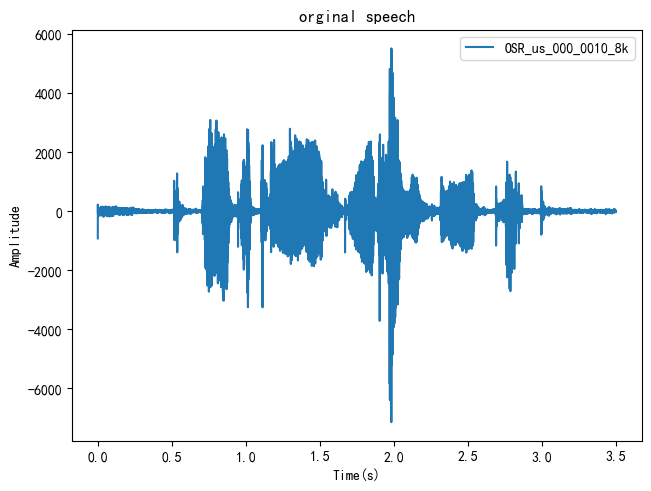

In [16]:
sample_rate, signal = scipy.io.wavfile.read('american_english/OSR_us_000_0010_8k.wav')
signal = signal[0:int(3.5*sample_rate)] # 只取前3.5s
pre_emphasis =0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
x_time = np.linspace(0, 3.5, int(3.5*sample_rate))

plt.rcParams['axes.unicode_minus'] =False
fig, ax = plt.subplots(layout='constrained')
ax.plot(x_time, emphasized_signal, label='OSR_us_000_0010_8k')
ax.set_xlabel("Time(s)")
ax.set_ylabel('Amplitude')
ax.set_title('orginal speech')
plt.legend()

#### 分帧(Framing)
在预加重之后，我们需要将信号分成短时帧。因此在大多数情况下，语音信号是非平稳的，对整个信号进行傅里叶变换是没有意义的，因为我们会随着时间的推移丢失信号的频率轮廓。语音信号是短时平稳信号。因此我们在短时帧上进行傅里叶变换，通过连接相邻帧来获得信号频率轮廓的良好近似。

将信号帧化为20-40 ms帧。标准是25毫秒 frame_size = 0.025。这意味着8kHz信号的帧长度为0.025 * 8000 = 200个采样点。帧移通常为10毫秒 frame_stride = 0.01（80个采样点），为了避免相邻两帧的变化过大，因此会让两相邻帧之间有一段重叠区域，通常约为每帧语音的1/2或1/3或50%(+/-10%)，我们设置为15毫秒 overlap=0.015，因此此重叠区域包含了0.015*8000=120个取样点。第一个语音帧0开始，下一个语音帧从80开始，直到到达语音文件的末尾。如果语音文件没有划分为偶数个帧，则用零填充它以使其完成。

#### 加窗(Window)

将信号分割成帧后，我们再对每个帧乘以一个窗函数，如Hamming窗口。以增加帧左端和右端的连续性。抵消FFT假设（数据是无限的），并减少频谱泄漏。汉明窗的形式如下：
$$W(n,a) = (1-a) -a \times \cos(\frac{2\pi n}{N-1}) \quad 0 \leq n \leq N-1$$
N是窗口长度，假设a=0.46。

### 快速傅里叶变换FFT(Fourier-Transform)
由于信号在时域上的变换通常很难看出信号的特性，通常对它做FFT变换转换为频域上的能量分布来观察，不同的能量分布，就能代表不同语音的特性。

接下来我们对分帧加窗后的各帧信号进行做一个N点FFT来计算频谱，也称为短时傅立叶变换（STFT），其中N通常为256或512，NFFT=512；
$$S_i(k)=\sum_{n=1}^{N}s_i(n)e^{\frac{-j2\pi kn}{N}} \quad 1 \leq k \leq K$$

### 功率谱(Power Spectrum)
然后我们使用以下公式计算功率谱（周期图periodogram），对语音信号的频谱取模平方（取对数或者去平方，因为频率不可能为负，负值要舍去）得到语音信号的谱线能量。

$$P=\frac{\vert FFT(x_i) \vert^2}{N}$$
 

其中，$X_i$是信号X的第i帧，这可以用以下几行来实现：$pow_frames = ((1.0 / NFFT) * ((mag\_frames) ** 2))$

### 滤波器组 (Filter Banks）

计算Mel滤波器组，将功率谱通过一组Mel刻度(通常取40个滤波器，nfilt=40)的三角滤波器(triangular filters)来提取频带(frequency bands)。

这个Mel滤波器组就像人类的听觉感知系统（耳朵），人耳只关注某些特定的频率分量（人的听觉对频率是有选择性的）。它对不同频率信号的灵敏度是不同的，换言之，它只让某些频率的信号通过，而压根就直接无视它不想感知的某些频率信号。但是这些滤波器在频率坐标轴上却不是统一分布的，在低频区域有很多的滤波器，他们分布比较密集，但在高频区域，滤波器的数目就变得比较少，分布很稀疏。因此Mel刻度的目的是模拟人耳对声音的非线性感知，在较低的频率具有更强的辨别力。我们可以使用以下公式在频率(f)和梅尔频率(m)之间进行转换：

我们可以用下面的公式，在语音频率和Mel频率间转换

- 从频率转换为梅尔刻度的公式为：$f_{mel}=2595*\log_{10}(1+\frac{f}{700})$
- 从梅尔回到频率：$f=700(10^{f_{mel}/2595}-1)$

定义一个有M个三角滤波器的滤波器组（滤波器的个数和临界带的个数相近），M通常取22-40，26是标准，本文取nfilt = 40。滤波器组中的每个滤波器都是三角形的，中心频率为f(m) ，中心频率处的响应为1，并向0线性减小，直到达到两个相邻滤波器的中心频率，其中响应为0，各f(m)之间的间隔随着m值的增大而增宽，如图所示：

这可以通过以下等式建模，三角滤波器的频率响应定义为: 
$$
H_m(k)=\begin{cases} 
0 &k\lt f(m-1) \\
\frac{k-f(m-1)}{f(m)-f(m-1)} &f(m-1)\leq k \leq f(m) \\
1 &k=f(m) \\
\frac{f(m+1)-k}{f(m+1)-f(m)} &f(m) \lt k \leq f(m+1) \\
0 &k \gt f(m+1)
\end{cases}
$$

对于FFT得到的幅度谱，分别跟每一个滤波器进行频率相乘累加，得到的值即为该帧数据在该滤波器对应频段的能量值。如果滤波器的个数为22，那么此时应该得到22个能量值

信号的功率谱经过 Filter Bank 后，得到的谱图为:

如果经过Mel scale滤波器组是所需的特征，那么我们可以跳过下一步。

### 梅尔频率倒谱系数(MFCCs)
上一步骤中计算的滤波器组系数是高度相关的，这在某些机器学习算法中可能是有问题的。因此，我们可以应用离散余弦变换（DCT）对滤波器组系数去相关处理，并产生滤波器组的压缩表示。通常，对于自动语音识别（ASR），保留所得到的个倒频谱系数2-13，其余部分被丢弃; 我们这里取 num_ceps = 12。丢弃其他系数的原因是它们代表了滤波器组系数的快速变化，并且这些精细的细节对自动语音识别（ASR）没有贡献。
$$C(n)=\sum_{m=0}^{N-1}s(m)\cos(\frac{\pi n(m-0.5)}{M}) \quad n=1,2,\cdots,L$$

L阶指MFCC系数阶数，通常取2-13。这里M是三角滤波器个数。
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # 保持在2-13



可以将正弦提升器(Liftering在倒谱域中进行过滤。 注意在谱图和倒谱图中分别使用filtering和liftering)应用于MFCC以去强调更高的MFCC，其已被证明可以改善噪声信号中的语音识别。
生成的MFCC：

### 均值归一化（Mean Normalization）
如前所述，为了平衡频谱并改善信噪比（SNR），我们可以简单地从所有帧中减去每个系数的平均值。
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

## 总结